# Visualizing results: Astromer 

In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from src.data import pretraining_pipeline
from src.models import get_ASTROMER
from src.utils import get_metrics
import tomli

from sklearn.metrics import r2_score, mean_squared_error

os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

%load_ext autoreload
%autoreload 2

2023-07-03 17:03:41.010540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 17:03:41.241686: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 17:03:41.328851: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Experiment folder

- `astromer_clean_1e-5_alpha_1_80p`,
- `astromer_noisy_1e-5_alpha_2`,
- `astromer_noisy_1e-3_alpha_1`,
- `astromer_clean_1e-5_alpha_1_50p`,
- `astromer_clean_1e-3_alpha_1_50p`,
- `astromer_clean_1e-5_alpha_2`,
- `astromer_clean_1e-5_alpha_1_20p`,
- `astromer_noisy_1e-3_alpha_2`,
- `astromer_noisy_1e-5_alpha_1`,
- `astromer_clean_1e-5_alpha_1_10p`,
- `bugstromer_clean_1e-5_alpha_2`: ASTROMER no-mask trained on clean MACHO dataset,
- `paper`: Bugstromer trained on noisy MACHO
- `astromer_clean_1e-3_alpha_1_20p_minmax`'

In [181]:
name_exp = 'astromer_clean'
path_ckpts = f'./presentation/experiments/astromer_0/backup/errata/results/{name_exp}/'
path_conf = f'./presentation/experiments/astromer_0/backup/errata/config/{name_exp}/alcock.100.f0.a.toml'

with open(path_conf, mode="rb") as fp:
    config = tomli.load(fp)     
    mask_frac = int(config['masking']['mask_frac']*100)

## Loading testing data and model 

In [182]:
# LOADING DATA
BATCH_SIZE = 32
test_batches = pretraining_pipeline(os.path.join(config['pretraining']['data']['path'], 'test'),
                                    BATCH_SIZE,
                                    config['astromer']['window_size'],
                                    0.,
                                    0.,
                                    0.,
                                    sampling=False,
                                    shuffle=False,
                                    normalize=config['pretraining']['data']['normalize'],
                                    cache=config['pretraining']['data']['cache_test'])

[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking


In [183]:
d_model = config['astromer']['head_dim']*config['astromer']['heads']
astromer =  get_ASTROMER(num_layers=config['astromer']['layers'],
                         d_model=d_model,
                         num_heads=config['astromer']['heads'],
                         dff=config['astromer']['dff'],
                         base=config['positional']['base'],
                         dropout=config['astromer']['dropout'],
                         maxlen=config['astromer']['window_size'],
                         pe_c=config['positional']['alpha'],
                         no_train=False)

astromer.load_weights(os.path.join(path_ckpts, 'pretraining','weights')).expect_partial()
optimizer = tf.optimizers.Adam(1e-3)
astromer.compile(optimizer=optimizer)

PE_C RECEIVED:  tf.Tensor(2.0, shape=(), dtype=float32)


## Learning curves

In [184]:
test_df = pd.read_csv(os.path.join(path_ckpts, 'pretraining', 'metrics.csv'))
test_metrics = {
    'epoch_loss':test_df[test_df['step']=='pretraining']['rmse'].values[0], 
    'epoch_r_square':test_df[test_df['step']=='pretraining']['r_square'].values[0]
}

# test_metrics = {'epoch_loss':test_rmse, 'epoch_r_square':test_r2}
test_metrics

{'epoch_loss': 0.1034286618232727, 'epoch_r_square': 0.7256374359130859}

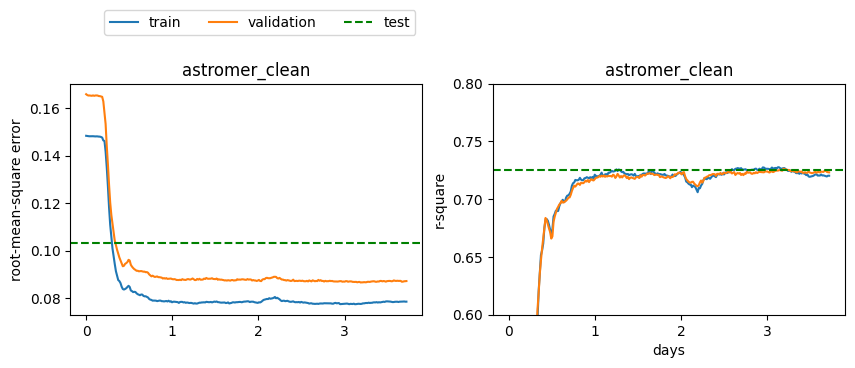

In [185]:
fig, axes = plt.subplots(1, 2, figsize=(10,3), sharex=True)

ft_name_metric = ['rmse', 'r_square']
titles = ['root-mean-square error', 'r-square']
for i, metric_name in enumerate(['epoch_loss', 'epoch_r_square']):
    val_logs = get_metrics(os.path.join(path_ckpts, 'pretraining', 'logs', 'validation'), 
                           show_keys=False, full_logs=True, metric_name=metric_name)    
    train_logs = get_metrics(os.path.join(path_ckpts, 'pretraining', 'logs', 'train'), 
                                 show_keys=False, full_logs=True, metric_name=metric_name, nlog=0)       
    
    train_logs['wall_time'] = (train_logs['wall_time'] - train_logs['wall_time'].iloc[0])/(60*60*24)
    val_logs['wall_time'] = (val_logs['wall_time'] - val_logs['wall_time'].iloc[0])/(60*60*24)

    axes[i].plot(train_logs['wall_time'].values, train_logs['value'].values, label='train')
    axes[i].plot(val_logs['wall_time'].values, val_logs['value'].values, label='validation')
        
    axes[i].axhline(y=test_metrics[metric_name], color='g', linestyle='--', label='test')
    axes[i].set_ylabel(titles[i])
    
axes[-1].set_xlabel('days')
axes[0].set_title(f'{name_exp}')
axes[0].legend(bbox_to_anchor = (1., 1.35), ncol=3)
axes[-1].set_ylim(0.6, 0.8)
axes[-1].set_title(f'{name_exp}')
plt.show()

## Reconstruction 

In [186]:
%%time
for x, y in test_batches.take(1): #only one batch
    y_pred = astromer(x)
    y_true = y['target']
    y_time = x['times']
    y_oerr = y['error']
    encoder = astromer.get_layer('encoder')
    output, weights = encoder(x, return_weights=True)  

CPU times: user 1.85 s, sys: 81.3 ms, total: 1.93 s
Wall time: 778 ms


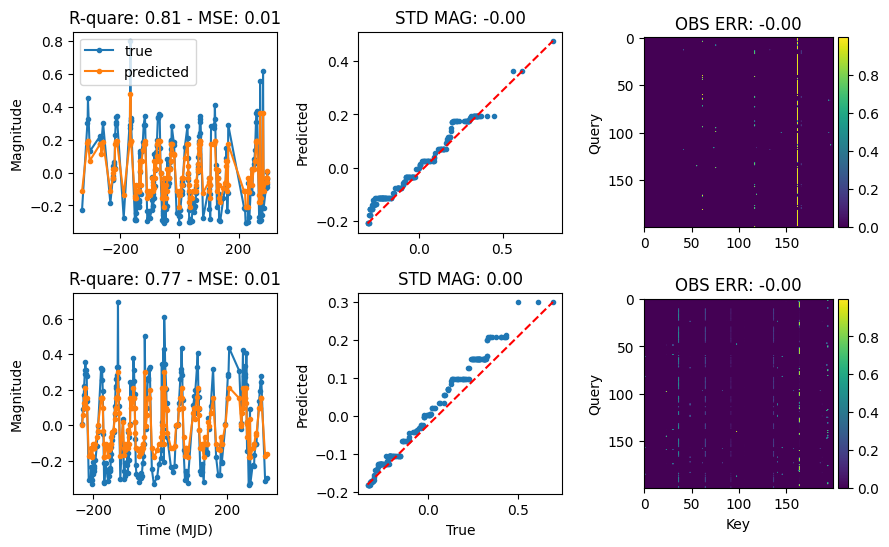

In [187]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

N = 2
fig, axes = plt.subplots(N, 3, figsize=(10,6), gridspec_kw={'hspace': 0.3, 'wspace': 0.4})

for i in range(N):  
    residuals = y_true[i] - y_pred[i]
    mse      = mean_squared_error(y_true[i], y_pred[i])
    std_mag  = np.mean(y_true[i])
    obs_err  = np.mean(y_oerr[i]) 
    r2_value = r2_score(y_true[i], y_pred[i])
    
    axes[i][0].set_title('R-quare: {:.2f} - MSE: {:.2f}'.format(r2_value, mse))
    axes[i][1].set_title('STD MAG: {:.2f}'.format(std_mag))
    axes[i][2].set_title('OBS ERR: {:.2f}'.format(obs_err))
    axes[i][0].plot(y_time[i], y_true[i], marker='.', label='true')
    axes[i][0].plot(y_time[i], y_pred[i], marker='.', label='predicted')
    axes[i][1].plot(y_true[i], y_pred[i], marker='.', linestyle='')
    axes[i][1].plot([min(y_true[i]), max(y_true[i])], [min(y_pred[i]), max(y_pred[i])], 'r--')
    
    im = axes[i][2].imshow(weights[i][0])
    axes[i][0].set_ylabel('Magnitude')
    axes[i][1].set_ylabel('Predicted')
    axes[i][2].set_ylabel('Query')
    
    divider = make_axes_locatable(axes[i][2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax)

axes[-1][0].set_xlabel('Time (MJD)')
axes[-1][1].set_xlabel('True')
axes[-1][2].set_xlabel('Key')
axes[0][0].legend()

## Classification

In [188]:
styles = {'mlp_att':{'marker':'^', 'linestyle':'-', 'name':'MLP+ATT'}, 
          'lstm_att':{'marker':'o', 'linestyle':'--', 'name':'LSTM+ATT'}, 
          'lstm':{'marker':'s', 'linestyle':':', 'name':'Baseline'},
          'mlp_att_conv':{'marker':'.', 'linestyle':'--', 'name':'MLP+ATT+CONV'},
          'mlp_first':{'marker':'*', 'linestyle':':', 'name':'MLP+FIRST'},
          'mlp_last':{'marker':'v', 'linestyle':'-', 'name':'MLP+LAST'},
         }

ft_names_changed = {
    'alcock': 'MACHO', 'atlas': 'ATLAS', 'ogle':'OGLE-III'
}
path_ckpts, target

('./presentation/experiments/astromer_0/backup/errata/results/astromer_clean/',
 'atlas')

In [193]:
# to_change = {'b':'a'}
# dsname = 'atlas'
# clf_metrics = pd.read_csv(os.path.join(path_ckpts, dsname, 'classification','metrics.csv'))
# clf_metrics['sci_case'] = clf_metrics['sci_case'].apply(lambda x: to_change[x])
# clf_metrics.to_csv(os.path.join(path_ckpts, dsname, 'classification','metrics.csv'), index=False)

Text(0.51, 0.05, 'Samples per class')

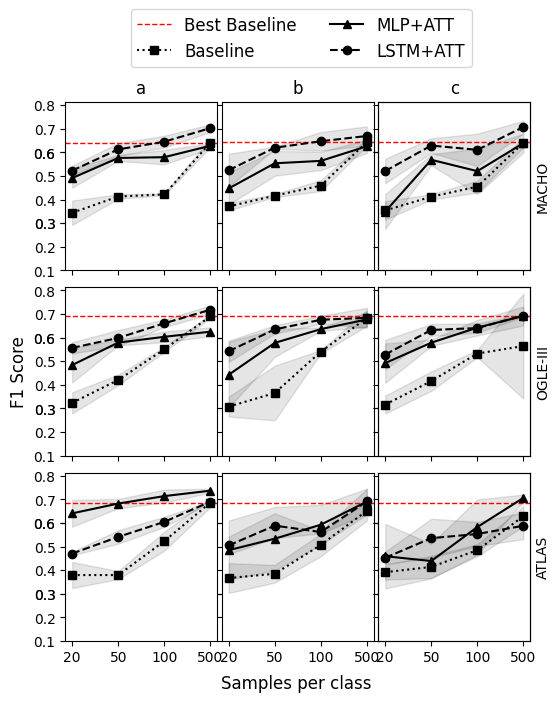

In [194]:
### marker_models = ['s', '^', 'o', 'v']
fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(6,7), 
                         gridspec_kw={'hspace': 0.1, 'wspace': 0.03})
    
for row, target in enumerate(['alcock', 'ogle', 'atlas']):
    clf_metrics = pd.read_csv(os.path.join(path_ckpts, target, 'classification_dp_activated','metrics.csv'))
    best_baseline = []
    for col, sci_case in enumerate(['a', 'b', 'c']):
        try:
            if row == 0:
                axes[row][col].set_title(sci_case)

            for model_index, clf_model in enumerate(['lstm', 'mlp_att','lstm_att']):
                partial = clf_metrics[(clf_metrics['target'] == target) & \
                                      (clf_metrics['sci_case'] == sci_case) & \
                                      (clf_metrics['model'] == clf_model)]

                spc_cases, scores_mean, scores_std = [], [], []
                for spc, frame in partial.groupby('spc'):
                    spc_cases.append(spc)
                    scores_mean.append(frame['test_f1'].mean())
                    scores_std.append(frame['test_f1'].std())

                x_whole = [20, 50, 100, 500]
                x_range = np.array([x_whole.index(c) for c in spc_cases])

                axes[row][col].errorbar(x_range, scores_mean, 
                                   marker=styles[clf_model]['marker'], 
                                   label=styles[clf_model]['name'],
                                   linestyle=styles[clf_model]['linestyle'],
                                   color='k')
                axes[row][col].fill_between(x_range, 
                                           np.array(scores_mean)+np.array(scores_std), 
                                           np.array(scores_mean)-np.array(scores_std),
                                           color='k', alpha=0.1)

                axes[row][col].set_xticks(x_range)
                axes[row][col].set_xticklabels([int(x) for x in spc_cases])
                axes[row][col].set_yticks([round(x, 1) for x in np.linspace(0.1, 0.8, 10)])


                if clf_model == 'lstm':
                    best_baseline.append(np.max(scores_mean))

            axes[row][col].axhline(y=np.max(best_baseline), 
                                   color='red', 
                                   linestyle='--', 
                                   linewidth=1, 
                                   label='Best Baseline')

            if col == 2:
                ax2 = axes[row][col].twinx()     
                ax2.set_yticks([])
                ax2.set_ylabel(ft_names_changed[target])
        except:
            continue
        

axes[1][0].set_ylabel('F1 Score', fontsize=12)
axes[0][1].legend(ncol=2, bbox_to_anchor = (1.7, 1.6), fontsize=12)
fig.text(0.51, 0.05, 'Samples per class', ha='center', va='center', fontsize=12)